In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from patsy import dmatrices
from imblearn.over_sampling import SMOTE
from itertools import combinations

In [3]:
# Read the datasets
option_data = pd.read_excel("Option Code Information file for UNT - Final.xlsx")
warranty_claim_data = pd.read_excel("Claim Information file for UNT.xlsx")

# Check for Null Values in datasets
option_data
warranty_claim_data
option_data.isnull().sum()
warranty_claim_data.isnull().sum()

# Formatting datasets to merge
option_data.rename(columns={'Truck': 'Truck_ID'}, inplace=True)
warranty_claim_data.rename(columns={'Truck Number': 'Truck_ID'}, inplace=True)
merged_data = pd.merge(option_data, warranty_claim_data, on='Truck_ID')
print(merged_data.info())
merged_data

,Truck,Style,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8
0,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294
1,Truck 2,Style 1,Option 2,Option 84,Option 181,Option 205,Option 265,Option 282,Option 291,Option 295
2,Truck 3,Style 1,Option 2,Option 84,Option 181,Option 205,Option 265,Option 282,Option 291,Option 295
3,Truck 4,Style 1,Option 2,Option 84,Option 181,Option 205,Option 265,Option 282,Option 291,Option 295
4,Truck 5,Style 1,Option 2,Option 84,Option 181,Option 205,Option 265,Option 282,Option 291,Option 295
...,...,...,...,...,...,...,...,...,...,...
48299,Truck 48300,Style 7,Option 32,Option 101,Option 187,Option 230,Option 265,Option 285,Option 291,Option 299
48300,Truck 48301,Style 7,Option 34,Option 98,Option 187,Option 217,Option 267,Option 285,Option 291,Option 301
48301,Truck 48302,Style 7,Option 34,Option 98,Option 188,Option 217,Option 267,Option 285,Option 291,Option 301
48302,Truck 48303,Style 7,Option 34,Option 98,Option 188,Option 217,Option 267,Option 285,Option 291,Option 301


,Truck Number,Claim Number,Scale Claim Cost,Scale Labor Cost
0,Truck 4208,Claim 1,Very Low,Very Low
1,Truck 22899,Claim 2,Very Low,Very Low
2,Truck 22899,Claim 3,Very Low,Very Low
3,Truck 9983,Claim 4,Very Low,Very Low
4,Truck 2426,Claim 5,Very Low,Very Low
...,...,...,...,...
123356,Truck 46939,Claim 123357,Very High,High
123357,Truck 46939,Claim 123358,Very High,Medium
123358,Truck 10,Claim 123359,Very High,Medium
123359,Truck 44270,Claim 123360,Very High,High


Truck          0
Style          0
Attribute 1    0
Attribute 2    0
Attribute 3    0
Attribute 4    0
Attribute 5    0
Attribute 6    0
Attribute 7    0
Attribute 8    0
dtype: int64

Truck Number        0
Claim Number        0
Scale Claim Cost    0
Scale Labor Cost    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123361 entries, 0 to 123360
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Truck_ID          123361 non-null  object
 1   Style             123361 non-null  object
 2   Attribute 1       123361 non-null  object
 3   Attribute 2       123361 non-null  object
 4   Attribute 3       123361 non-null  object
 5   Attribute 4       123361 non-null  object
 6   Attribute 5       123361 non-null  object
 7   Attribute 6       123361 non-null  object
 8   Attribute 7       123361 non-null  object
 9   Attribute 8       123361 non-null  object
 10  Claim Number      123361 non-null  object
 11  Scale Claim Cost  123361 non-null  object
 12  Scale Labor Cost  123361 non-null  object
dtypes: object(13)
memory usage: 12.2+ MB
None


,Truck_ID,Style,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,Claim Number,Scale Claim Cost,Scale Labor Cost
0,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 13675,Low,Low
1,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 18104,Low,Low
2,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 20261,Low,Low
3,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 21530,Low,Low
4,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 21693,Low,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123356,Truck 48300,Style 7,Option 32,Option 101,Option 187,Option 230,Option 265,Option 285,Option 291,Option 299,Claim 74908,Low,Very Low
123357,Truck 48300,Style 7,Option 32,Option 101,Option 187,Option 230,Option 265,Option 285,Option 291,Option 299,Claim 74909,Low,Very Low
123358,Truck 48304,Style 7,Option 36,Option 116,Option 181,Option 206,Option 267,Option283,Option 291,Option 301,Claim 162,Very Low,Very Low
123359,Truck 48304,Style 7,Option 36,Option 116,Option 181,Option 206,Option 267,Option283,Option 291,Option 301,Claim 29282,Very Low,Very Low


<BarContainer object of 80 artists>

<BarContainer object of 80 artists>

[Text(0, 0, 'Option 1'),
 Text(1, 0, 'Option 10'),
 Text(2, 0, 'Option 11'),
 Text(3, 0, 'Option 12'),
 Text(4, 0, 'Option 13'),
 Text(5, 0, 'Option 14'),
 Text(6, 0, 'Option 15'),
 Text(7, 0, 'Option 16'),
 Text(8, 0, 'Option 17'),
 Text(9, 0, 'Option 18'),
 Text(10, 0, 'Option 19'),
 Text(11, 0, 'Option 2'),
 Text(12, 0, 'Option 20'),
 Text(13, 0, 'Option 21'),
 Text(14, 0, 'Option 22'),
 Text(15, 0, 'Option 23'),
 Text(16, 0, 'Option 24'),
 Text(17, 0, 'Option 25'),
 Text(18, 0, 'Option 26'),
 Text(19, 0, 'Option 27'),
 Text(20, 0, 'Option 28'),
 Text(21, 0, 'Option 29'),
 Text(22, 0, 'Option 3'),
 Text(23, 0, 'Option 30'),
 Text(24, 0, 'Option 31'),
 Text(25, 0, 'Option 32'),
 Text(26, 0, 'Option 33'),
 Text(27, 0, 'Option 34'),
 Text(28, 0, 'Option 35'),
 Text(29, 0, 'Option 36'),
 Text(30, 0, 'Option 37'),
 Text(31, 0, 'Option 38'),
 Text(32, 0, 'Option 39'),
 Text(33, 0, 'Option 4'),
 Text(34, 0, 'Option 40'),
 Text(35, 0, 'Option 41'),
 Text(36, 0, 'Option 42'),
 Text(37, 0, 'O

Text(0.5, 1.0, 'Warranty Claims by Attribute 1 - Only Scale Claim Cost')

Text(0.5, 0, 'Attribute 1')

Text(0, 0.5, 'Proportion')

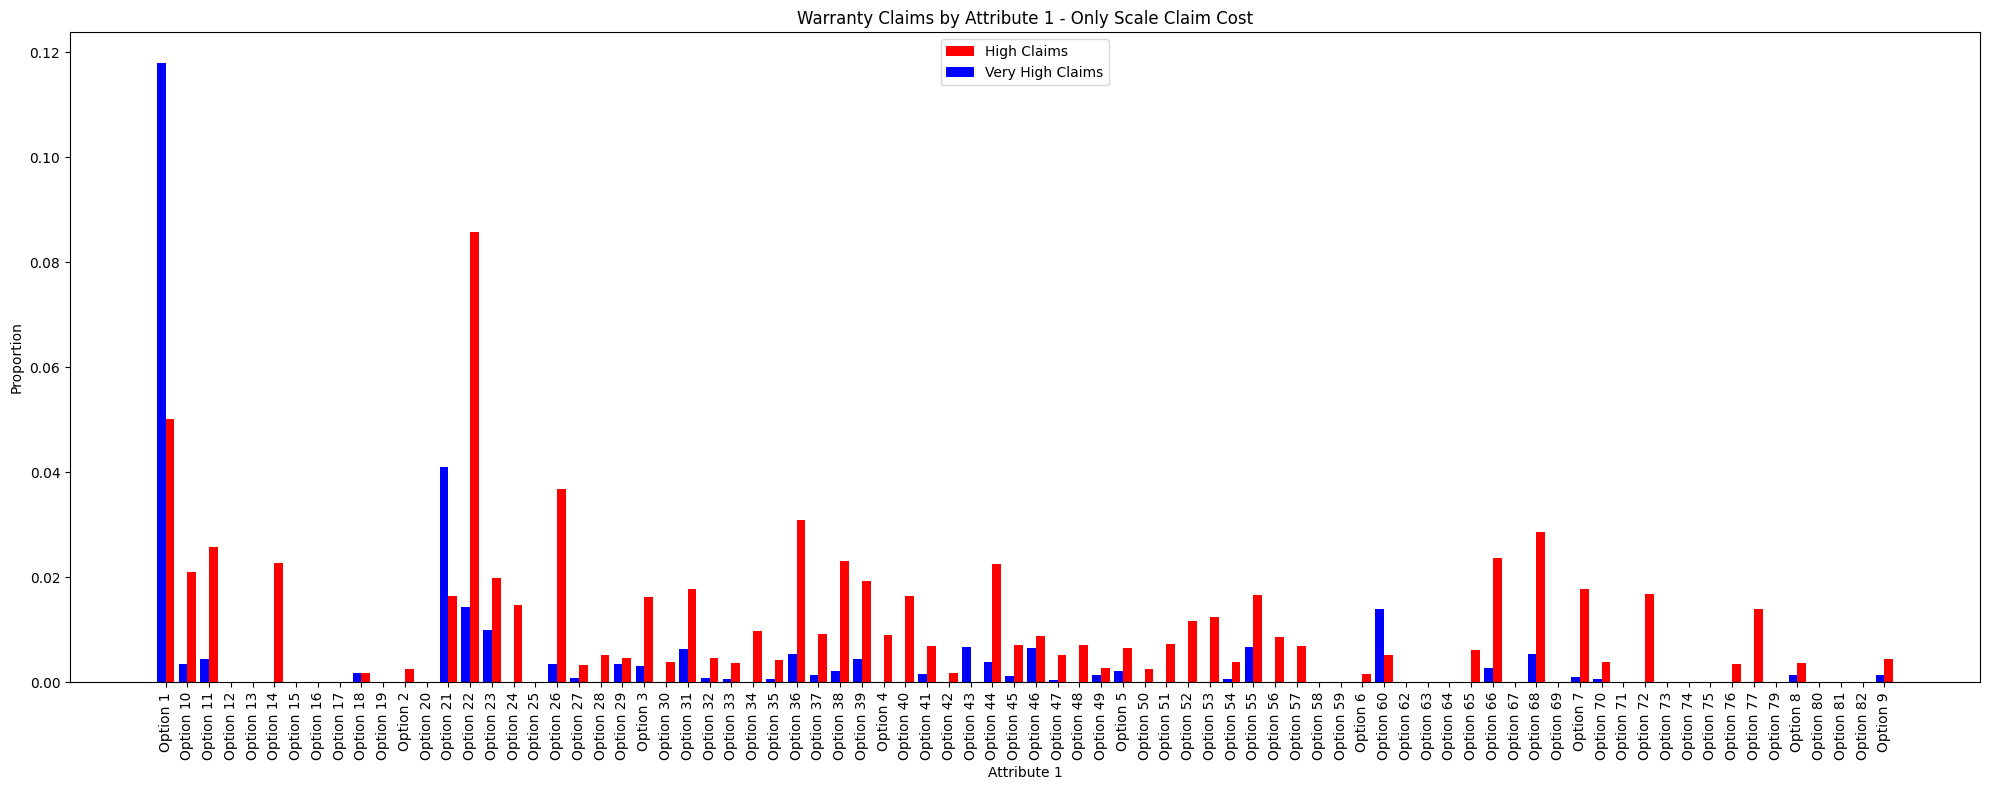

<BarContainer object of 94 artists>

<BarContainer object of 94 artists>

[Text(0, 0, 'Option 100'),
 Text(1, 0, 'Option 101'),
 Text(2, 0, 'Option 102'),
 Text(3, 0, 'Option 103'),
 Text(4, 0, 'Option 104'),
 Text(5, 0, 'Option 105'),
 Text(6, 0, 'Option 106'),
 Text(7, 0, 'Option 107'),
 Text(8, 0, 'Option 108'),
 Text(9, 0, 'Option 109'),
 Text(10, 0, 'Option 110'),
 Text(11, 0, 'Option 111'),
 Text(12, 0, 'Option 112'),
 Text(13, 0, 'Option 113'),
 Text(14, 0, 'Option 114'),
 Text(15, 0, 'Option 115'),
 Text(16, 0, 'Option 116'),
 Text(17, 0, 'Option 117'),
 Text(18, 0, 'Option 118'),
 Text(19, 0, 'Option 119'),
 Text(20, 0, 'Option 120'),
 Text(21, 0, 'Option 121'),
 Text(22, 0, 'Option 122'),
 Text(23, 0, 'Option 123'),
 Text(24, 0, 'Option 124'),
 Text(25, 0, 'Option 125'),
 Text(26, 0, 'Option 126'),
 Text(27, 0, 'Option 127'),
 Text(28, 0, 'Option 128'),
 Text(29, 0, 'Option 130'),
 Text(30, 0, 'Option 131'),
 Text(31, 0, 'Option 132'),
 Text(32, 0, 'Option 133'),
 Text(33, 0, 'Option 134'),
 Text(34, 0, 'Option 135'),
 Text(35, 0, 'Option 136'),
 T

Text(0.5, 1.0, 'Warranty Claims by Attribute 2 - Only Scale Claim Cost')

Text(0.5, 0, 'Attribute 2')

Text(0, 0.5, 'Proportion')

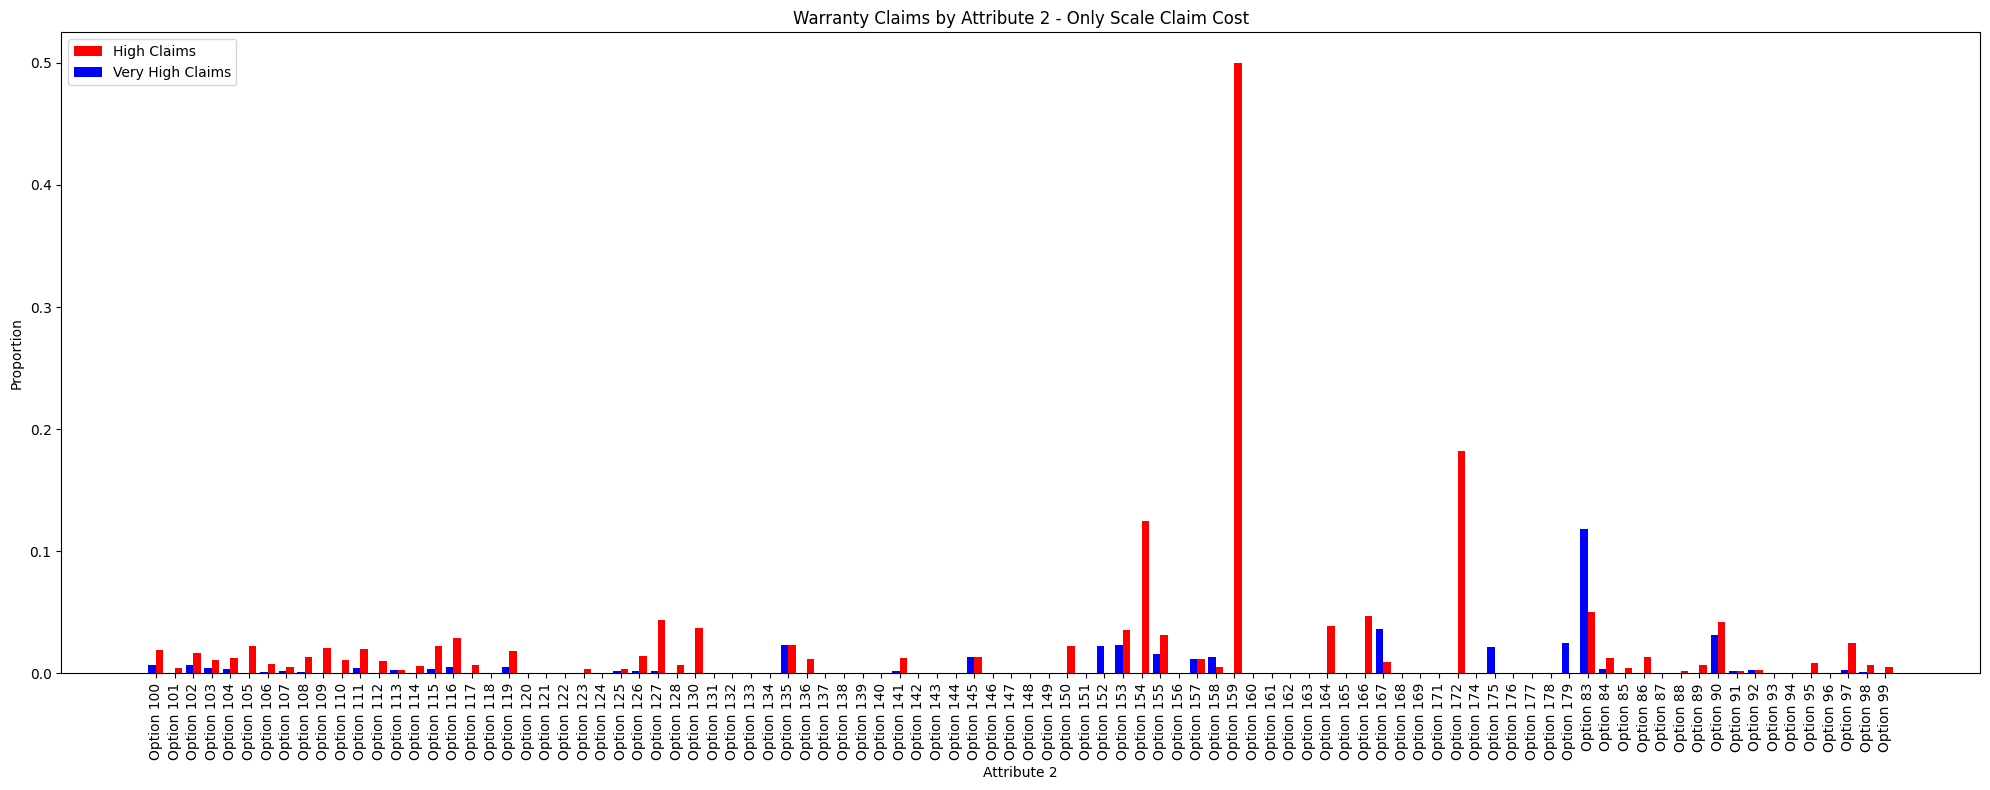

<BarContainer object of 21 artists>

<BarContainer object of 21 artists>

[Text(0, 0, 'Option 181'),
 Text(1, 0, 'Option 182'),
 Text(2, 0, 'Option 183'),
 Text(3, 0, 'Option 184'),
 Text(4, 0, 'Option 185'),
 Text(5, 0, 'Option 186'),
 Text(6, 0, 'Option 187'),
 Text(7, 0, 'Option 188'),
 Text(8, 0, 'Option 189'),
 Text(9, 0, 'Option 190'),
 Text(10, 0, 'Option 191'),
 Text(11, 0, 'Option 192'),
 Text(12, 0, 'Option 193'),
 Text(13, 0, 'Option 194'),
 Text(14, 0, 'Option 195'),
 Text(15, 0, 'Option 196'),
 Text(16, 0, 'Option 198'),
 Text(17, 0, 'Option 199'),
 Text(18, 0, 'Option 200'),
 Text(19, 0, 'Option 201'),
 Text(20, 0, 'Option 203')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 3 - Only Scale Claim Cost')

Text(0.5, 0, 'Attribute 3')

Text(0, 0.5, 'Proportion')

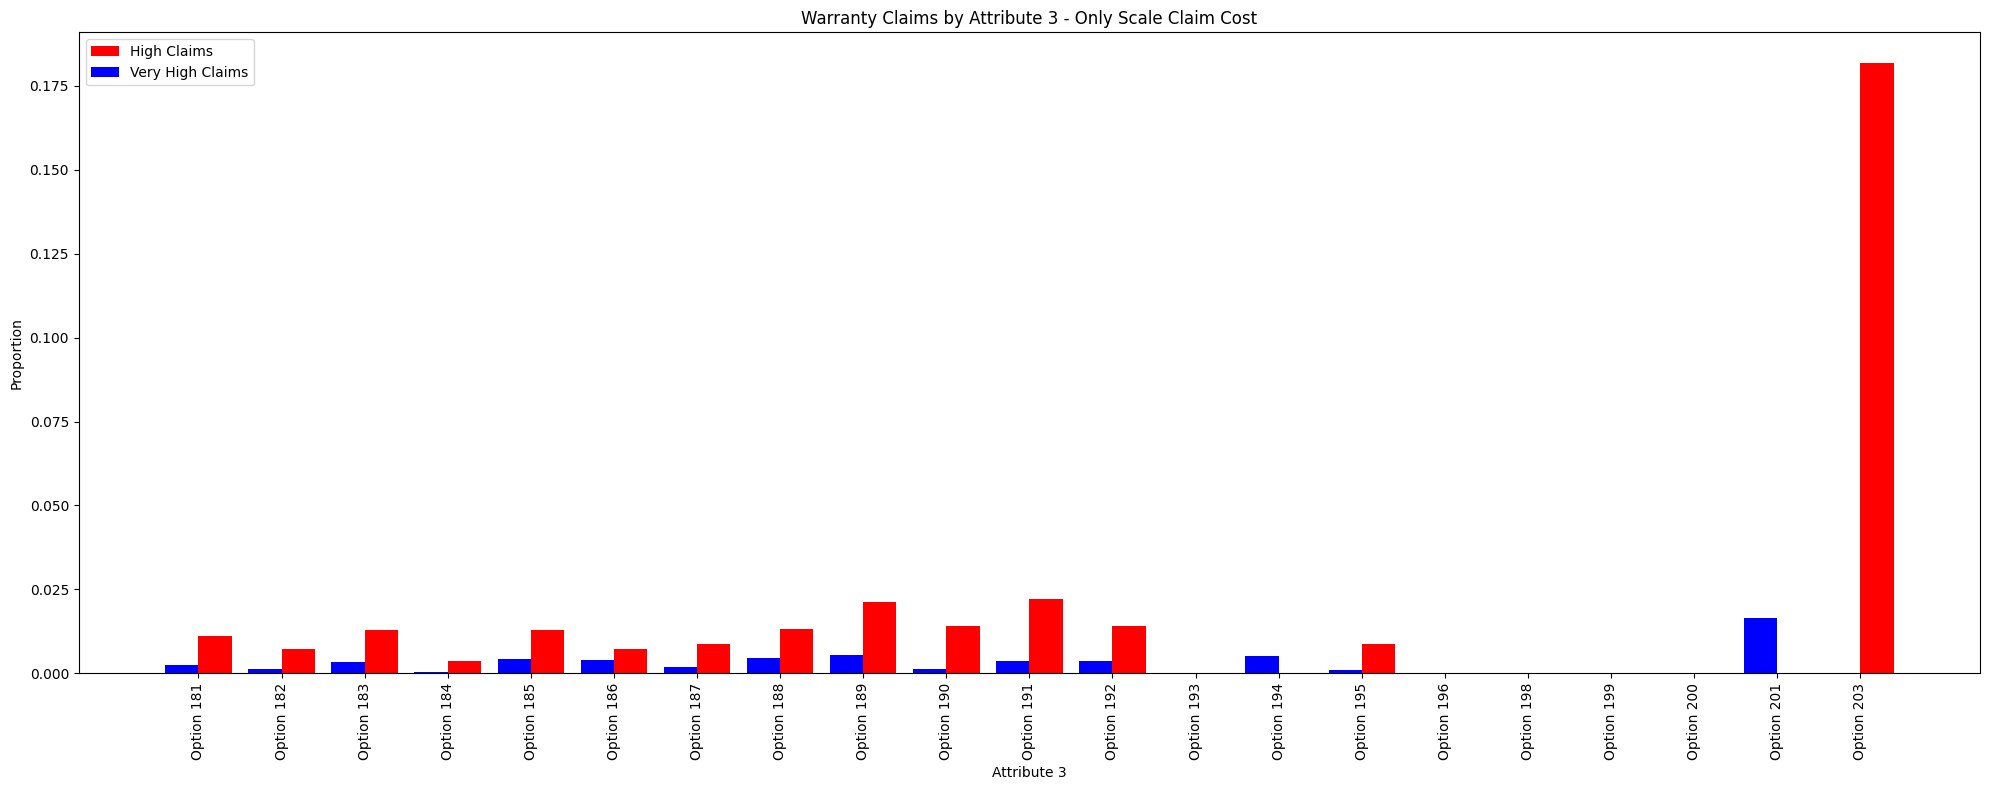

<BarContainer object of 56 artists>

<BarContainer object of 56 artists>

[Text(0, 0, 'Option 204'),
 Text(1, 0, 'Option 205'),
 Text(2, 0, 'Option 206'),
 Text(3, 0, 'Option 207'),
 Text(4, 0, 'Option 208'),
 Text(5, 0, 'Option 209'),
 Text(6, 0, 'Option 210'),
 Text(7, 0, 'Option 211'),
 Text(8, 0, 'Option 212'),
 Text(9, 0, 'Option 213'),
 Text(10, 0, 'Option 214'),
 Text(11, 0, 'Option 215'),
 Text(12, 0, 'Option 216'),
 Text(13, 0, 'Option 217'),
 Text(14, 0, 'Option 218'),
 Text(15, 0, 'Option 219'),
 Text(16, 0, 'Option 220'),
 Text(17, 0, 'Option 221'),
 Text(18, 0, 'Option 222'),
 Text(19, 0, 'Option 223'),
 Text(20, 0, 'Option 224'),
 Text(21, 0, 'Option 225'),
 Text(22, 0, 'Option 226'),
 Text(23, 0, 'Option 227'),
 Text(24, 0, 'Option 228'),
 Text(25, 0, 'Option 229'),
 Text(26, 0, 'Option 230'),
 Text(27, 0, 'Option 231'),
 Text(28, 0, 'Option 232'),
 Text(29, 0, 'Option 233'),
 Text(30, 0, 'Option 234'),
 Text(31, 0, 'Option 235'),
 Text(32, 0, 'Option 236'),
 Text(33, 0, 'Option 237'),
 Text(34, 0, 'Option 238'),
 Text(35, 0, 'Option 239'),
 T

Text(0.5, 1.0, 'Warranty Claims by Attribute 4 - Only Scale Claim Cost')

Text(0.5, 0, 'Attribute 4')

Text(0, 0.5, 'Proportion')

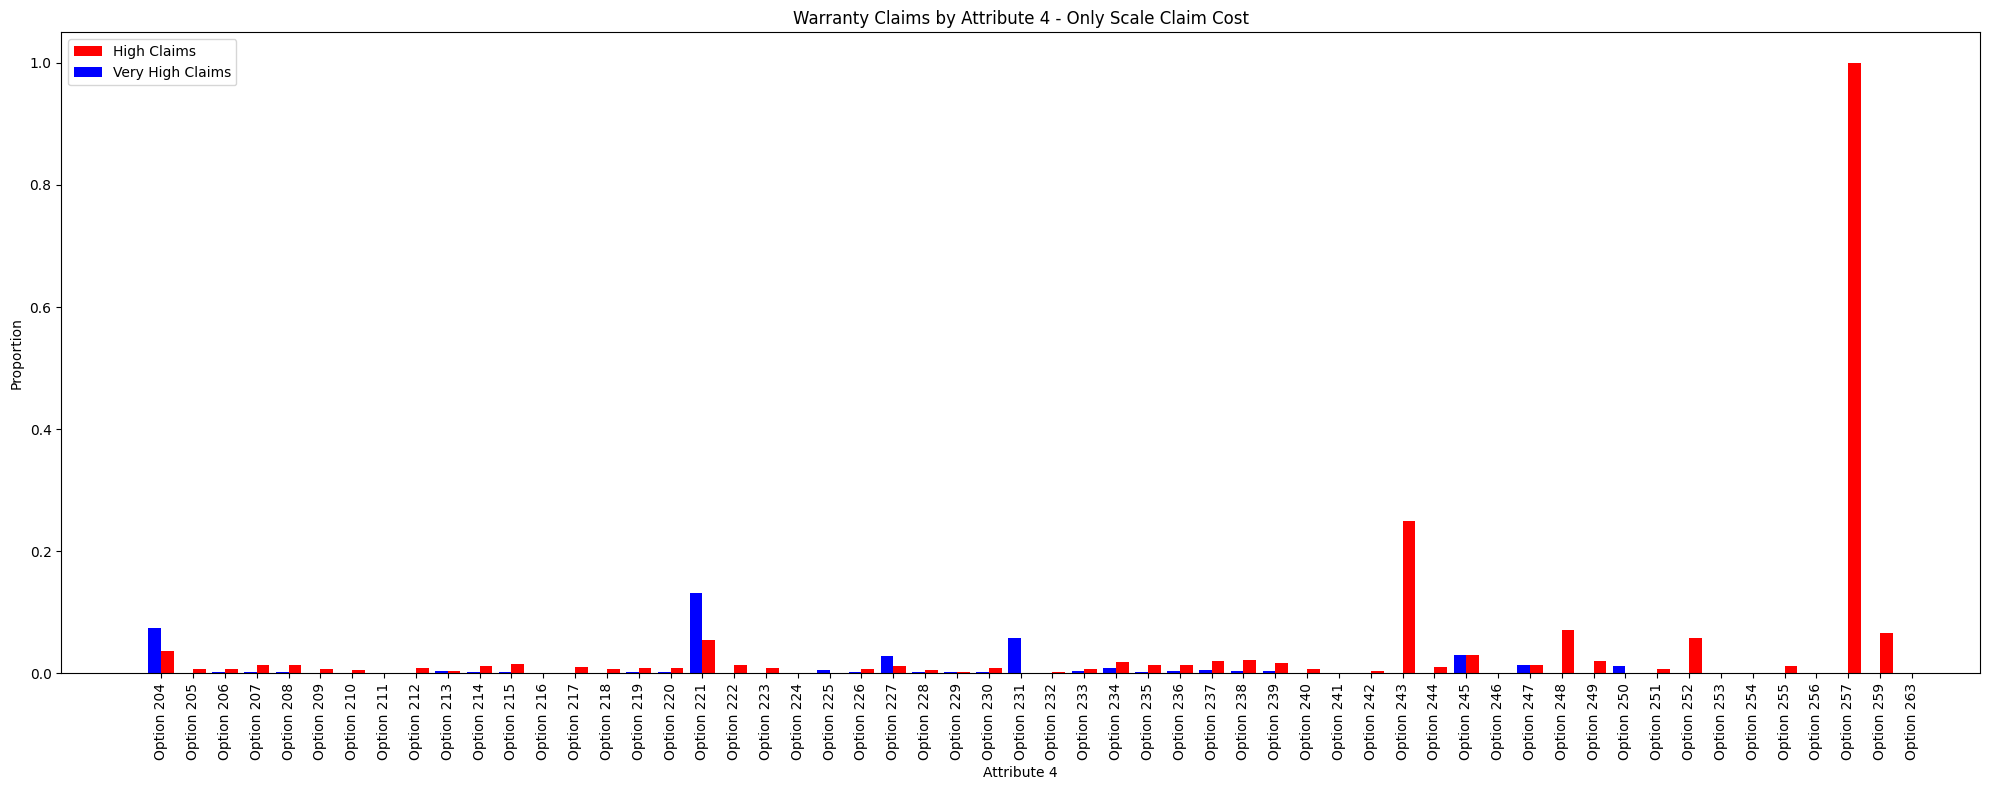

<BarContainer object of 16 artists>

<BarContainer object of 16 artists>

[Text(0, 0, 'Option 264'),
 Text(1, 0, 'Option 265'),
 Text(2, 0, 'Option 266'),
 Text(3, 0, 'Option 267'),
 Text(4, 0, 'Option 268'),
 Text(5, 0, 'Option 269'),
 Text(6, 0, 'Option 270'),
 Text(7, 0, 'Option 271'),
 Text(8, 0, 'Option 272'),
 Text(9, 0, 'Option 273'),
 Text(10, 0, 'Option 274'),
 Text(11, 0, 'Option 275'),
 Text(12, 0, 'Option 276'),
 Text(13, 0, 'Option 277'),
 Text(14, 0, 'Option 279'),
 Text(15, 0, 'Option 280')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 5 - Only Scale Claim Cost')

Text(0.5, 0, 'Attribute 5')

Text(0, 0.5, 'Proportion')

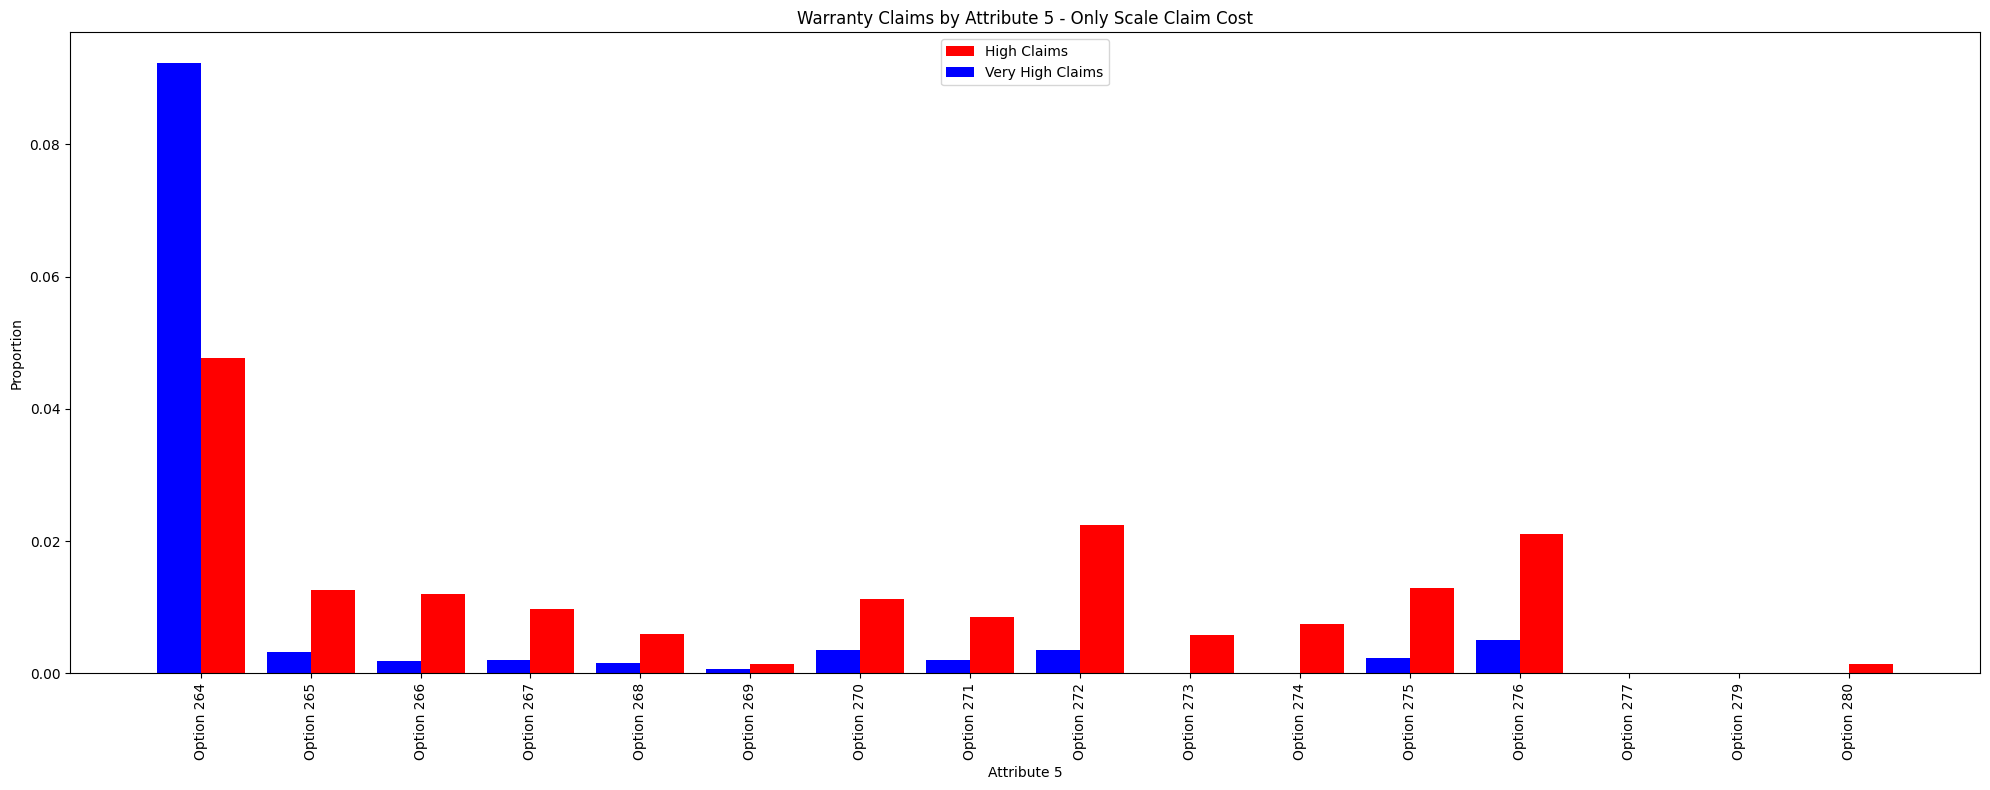

<BarContainer object of 9 artists>

<BarContainer object of 9 artists>

[Text(0, 0, 'Option 281'),
 Text(1, 0, 'Option 282'),
 Text(2, 0, 'Option 284'),
 Text(3, 0, 'Option 285'),
 Text(4, 0, 'Option 286'),
 Text(5, 0, 'Option 287'),
 Text(6, 0, 'Option 288'),
 Text(7, 0, 'Option 289'),
 Text(8, 0, 'Option283')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 6 - Only Scale Claim Cost')

Text(0.5, 0, 'Attribute 6')

Text(0, 0.5, 'Proportion')

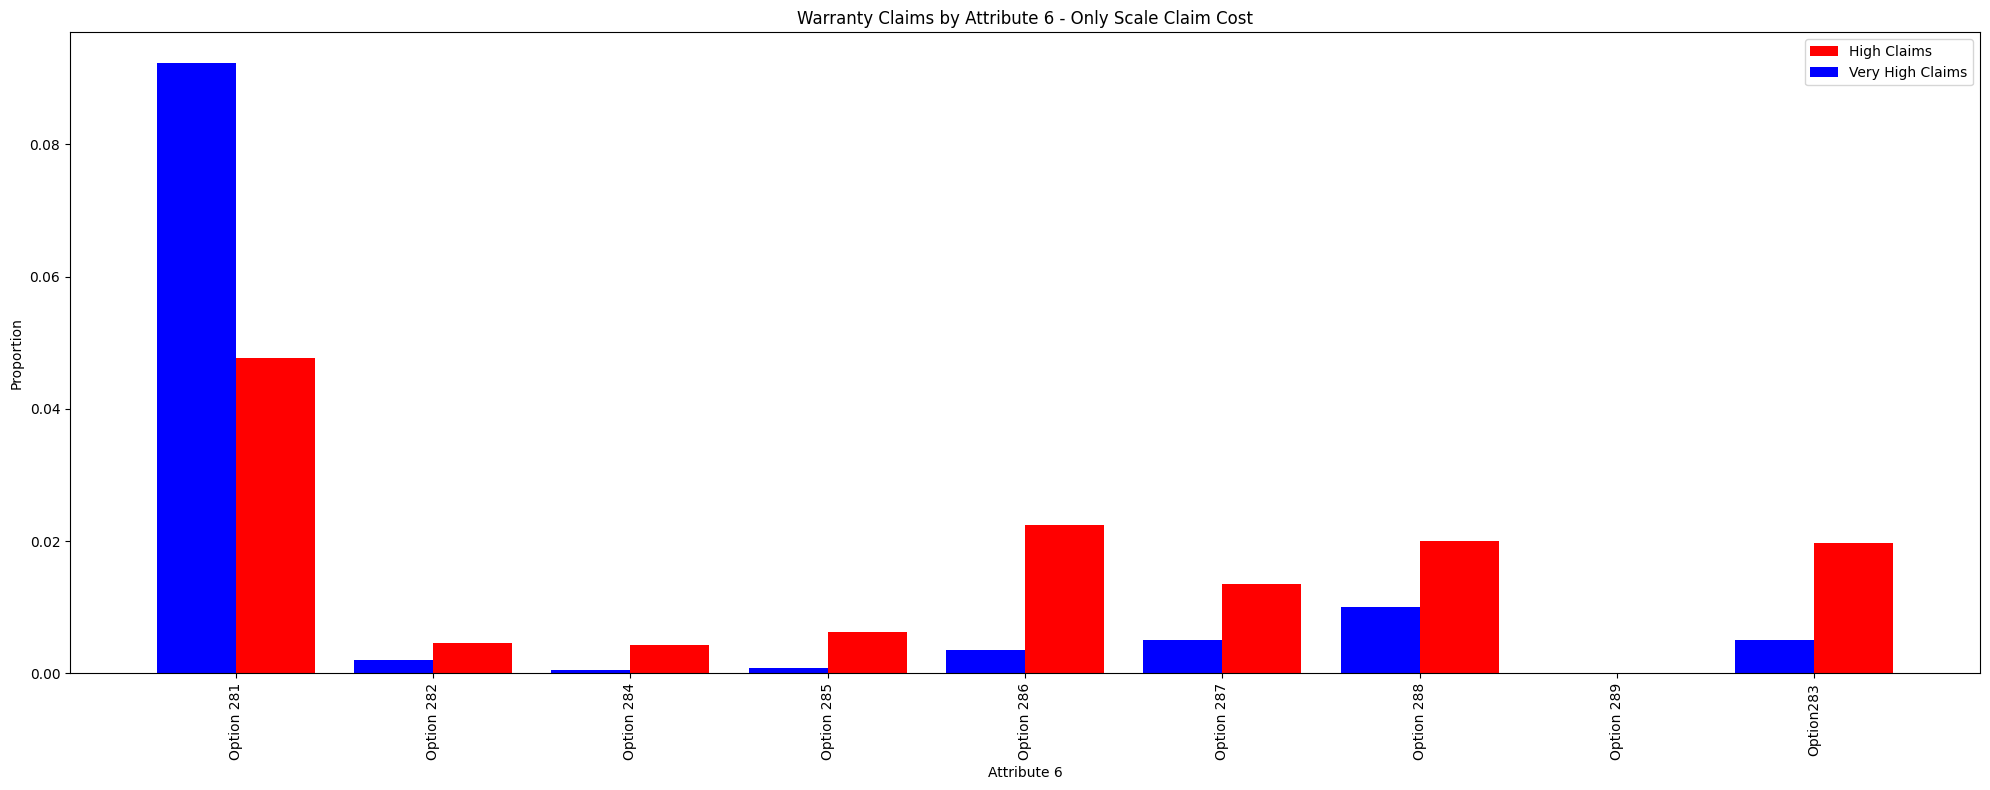

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

[Text(0, 0, 'Option 290'),
 Text(1, 0, 'Option 291'),
 Text(2, 0, 'Option 292'),
 Text(3, 0, 'Option 293')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 7 - Only Scale Claim Cost')

Text(0.5, 0, 'Attribute 7')

Text(0, 0.5, 'Proportion')

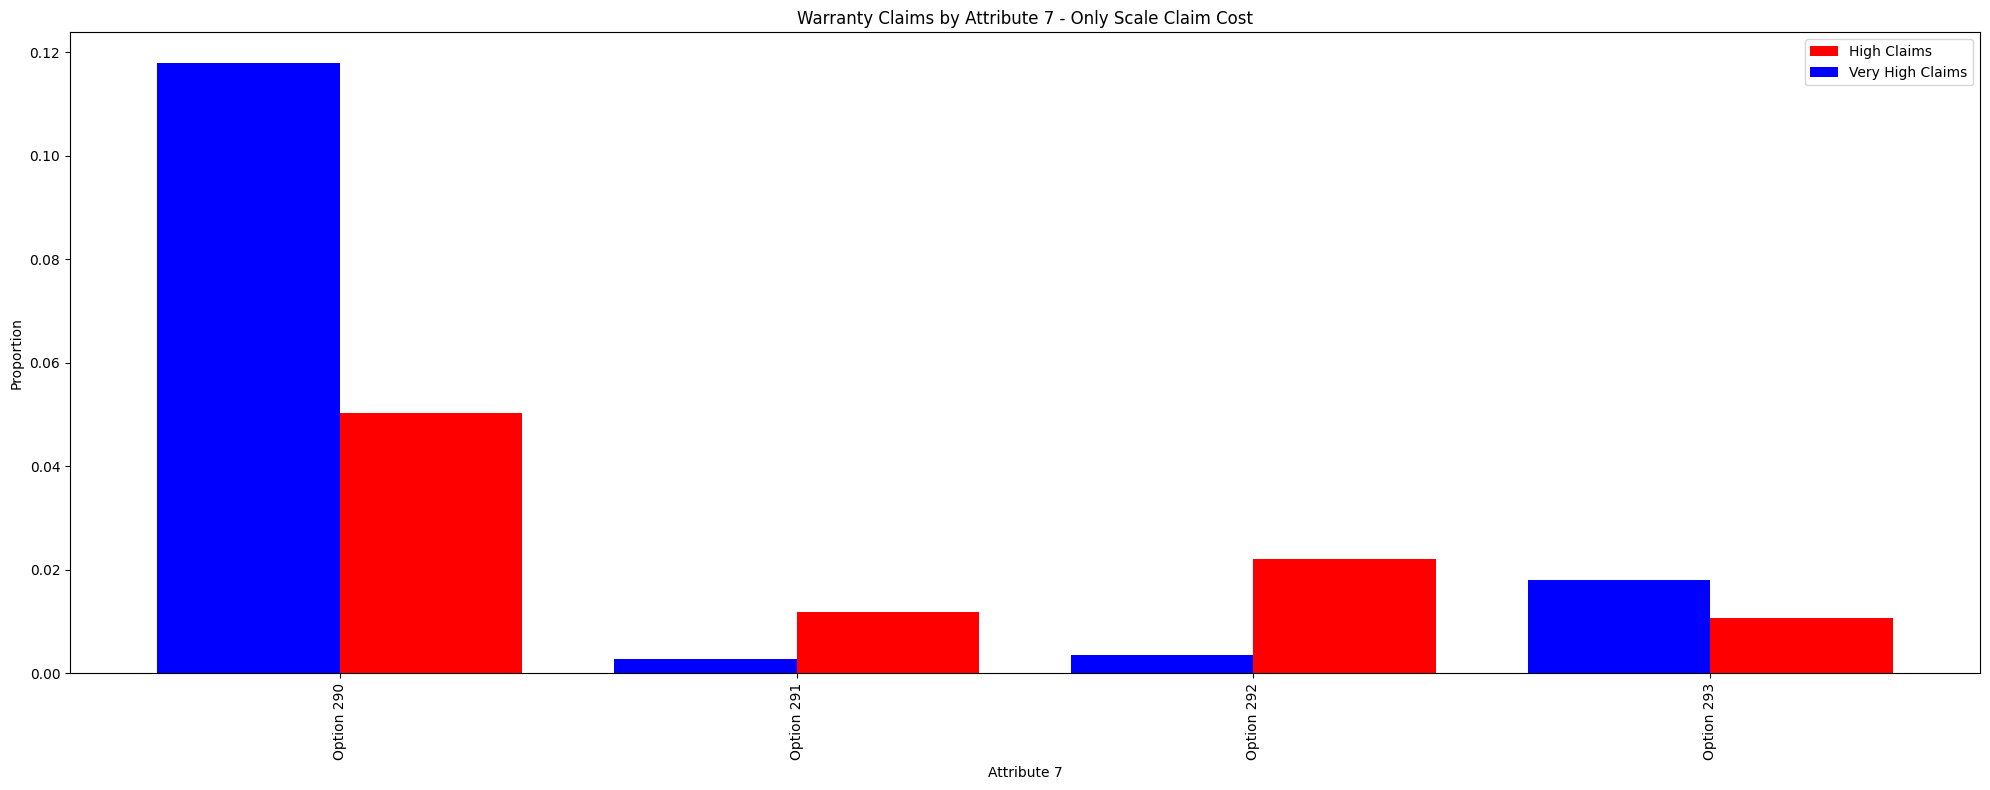

<BarContainer object of 21 artists>

<BarContainer object of 21 artists>

[Text(0, 0, 'Option 294'),
 Text(1, 0, 'Option 295'),
 Text(2, 0, 'Option 296'),
 Text(3, 0, 'Option 297'),
 Text(4, 0, 'Option 298'),
 Text(5, 0, 'Option 299'),
 Text(6, 0, 'Option 300'),
 Text(7, 0, 'Option 301'),
 Text(8, 0, 'Option 302'),
 Text(9, 0, 'Option 303'),
 Text(10, 0, 'Option 304'),
 Text(11, 0, 'Option 305'),
 Text(12, 0, 'Option 306'),
 Text(13, 0, 'Option 307'),
 Text(14, 0, 'Option 308'),
 Text(15, 0, 'Option 309'),
 Text(16, 0, 'Option 310'),
 Text(17, 0, 'Option 311'),
 Text(18, 0, 'Option 312'),
 Text(19, 0, 'Option 313'),
 Text(20, 0, 'Option 314')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 8 - Only Scale Claim Cost')

Text(0.5, 0, 'Attribute 8')

Text(0, 0.5, 'Proportion')

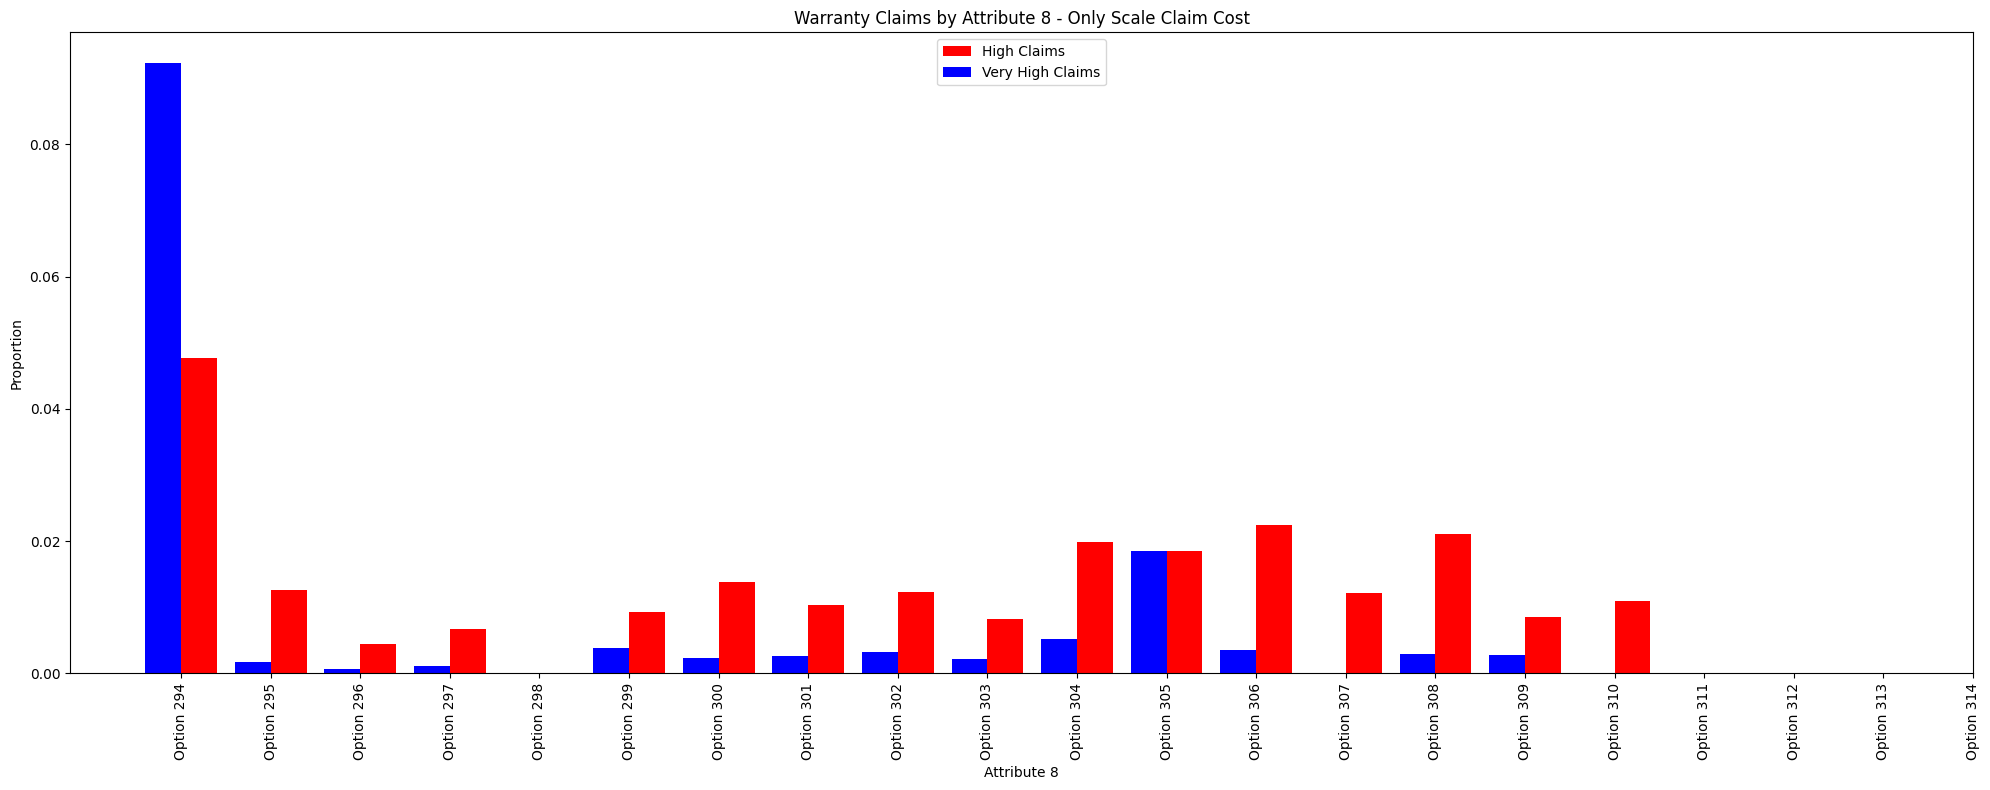

In [4]:
# This is for which option/subpart for each attribute is associated with increased warranty costs

# Define attribute columns to loop through
attributes = [f'Attribute {i}' for i in range(1, 9)]

for attr in attributes:
    # Calculate proportions of High and Very High claim costs per attribute
    high_claims = merged_data[merged_data['Scale Claim Cost'] == 'High'].groupby(attr).size() / merged_data.groupby(attr).size()
    very_high_claims = merged_data[merged_data['Scale Claim Cost'] == 'Very High'].groupby(attr).size() / merged_data.groupby(attr).size()

    # Plot
    fig, ax = plt.subplots(figsize=(20, 8))
    positions = range(len(high_claims))
    ax.bar([x + 0.2 for x in positions], high_claims, width=0.4, label='High Claims', color='red')
    ax.bar([x - 0.2 for x in positions], very_high_claims, width=0.4, label='Very High Claims', color='blue')
    ax.set_xticks(positions)
    ax.set_xticklabels(high_claims.index, rotation=90, ha='center')
    ax.set_title(f'Warranty Claims by {attr} - Only Scale Claim Cost')
    ax.set_xlabel(attr)
    ax.set_ylabel('Proportion')
    ax.legend()
    plt.tight_layout()
    plt.show()

<Axes: >

Text(0.5, 1.0, 'Version 1: Average Proportion of High Claims by Attribute Pair')

Text(0.5, 58.7222222222222, 'Attributes')

Text(170.72222222222223, 0.5, 'Attributes')

<Axes: >

Text(0.5, 1.0, 'Version 1: Average Proportion of Very High Claims by Attribute Pair')

Text(0.5, 58.7222222222222, 'Attributes')

Text(847.0858585858584, 0.5, 'Attributes')

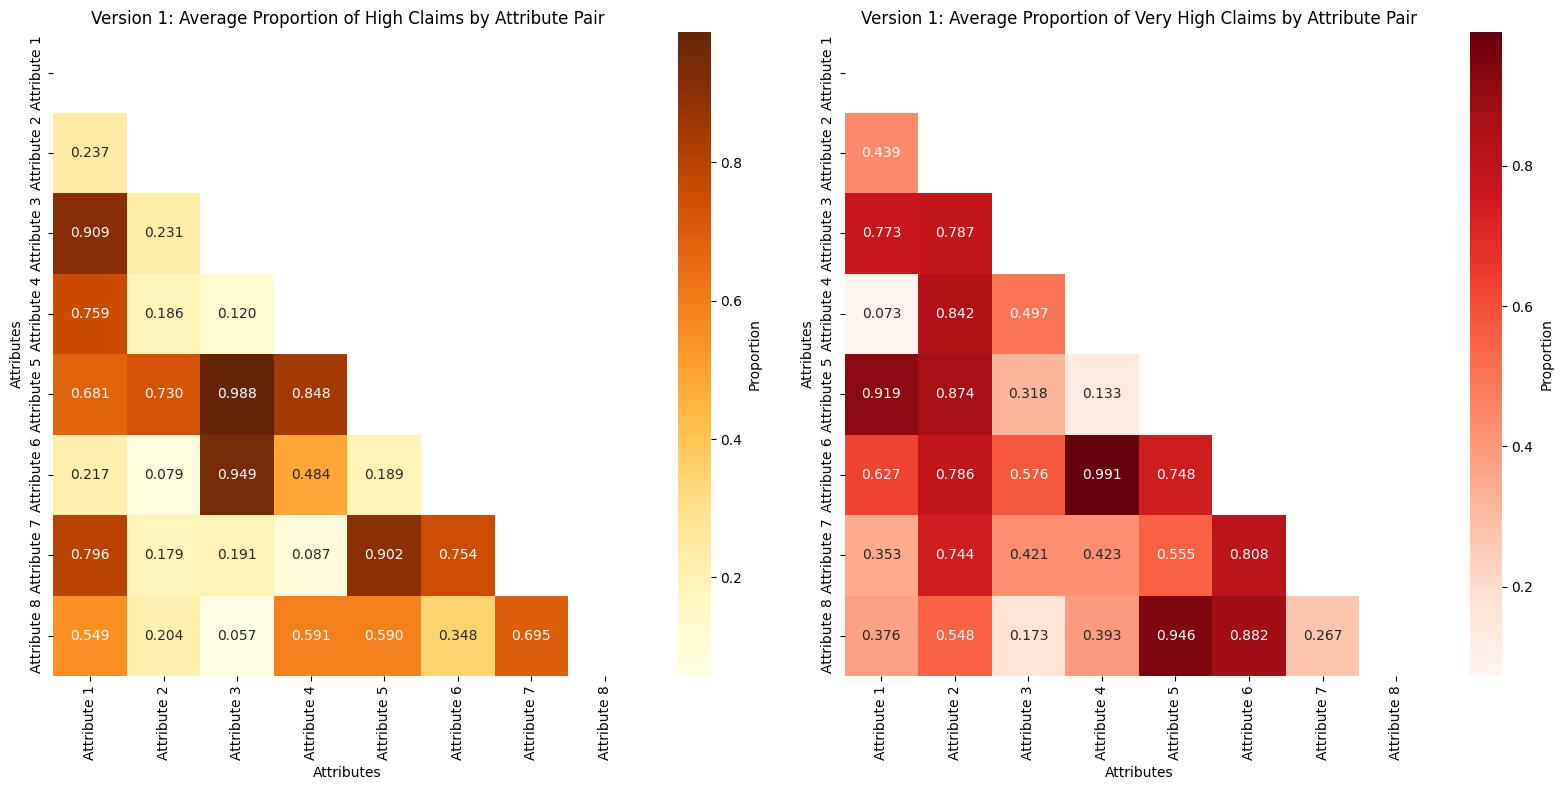

In [5]:
# what specific pairs of attribute/component when combines can exacerbates warranty claims.

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data creation, replace with actual high_matrix and very_high_matrix
attributes = [f'Attribute {i}' for i in range(1, 9)]
data_high = np.random.rand(8, 8)
data_very_high = np.random.rand(8, 8)
high_matrix = pd.DataFrame(data_high, index=attributes, columns=attributes)
very_high_matrix = pd.DataFrame(data_very_high, index=attributes, columns=attributes)

# Masking the upper triangle for a lower-triangle heatmap
mask = np.triu(np.ones_like(high_matrix, dtype=bool))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# High Claims Heatmap
sns.heatmap(high_matrix, mask=mask, annot=True, cmap="YlOrBr", fmt=".3f", ax=ax1, cbar_kws={'label': 'Proportion'})
ax1.set_title("Version 1: Average Proportion of High Claims by Attribute Pair")
ax1.set_xlabel("Attributes")
ax1.set_ylabel("Attributes")

# Very High Claims Heatmap
sns.heatmap(very_high_matrix, mask=mask, annot=True, cmap="Reds", fmt=".3f", ax=ax2, cbar_kws={'label': 'Proportion'})
ax2.set_title("Version 1: Average Proportion of Very High Claims by Attribute Pair")
ax2.set_xlabel("Attributes")
ax2.set_ylabel("Attributes")

plt.tight_layout()
plt.show()


In [6]:
# Identify Styles and Trucks Associated with Increased Warranty Costs

# Filter data for High and Very High Scale Claim Cost
high_claims_v1 = merged_data[merged_data['Scale Claim Cost'] == 'High']
very_high_claims_v1 = merged_data[merged_data['Scale Claim Cost'] == 'Very High']

# Group by Style and Truck_ID to get proportions for each attribute with High and Very High claims
high_claims_by_style_v1 = high_claims_v1.groupby(['Style', 'Truck_ID']).size() / merged_data.groupby(['Style', 'Truck_ID']).size()
very_high_claims_by_style_v1 = very_high_claims_v1.groupby(['Style', 'Truck_ID']).size() / merged_data.groupby(['Style', 'Truck_ID']).size()

# Display top 10 trucks with highest proportion of high and very high claim costs
print("Version 1: Top 10 Trucks with High Claim Costs (Scale Claim Cost)")
print(high_claims_by_style_v1.sort_values(ascending=False).head(10))

print("\nVersion 1: Top 10 Trucks with Very High Claim Costs (Scale Claim Cost)")
print(very_high_claims_by_style_v1.sort_values(ascending=False).head(10))


Version 1: Top 10 Trucks with High Claim Costs (Scale Claim Cost)
Style     Truck_ID   
Style 9   Truck 32520    1.0
Style 7   Truck 7609     1.0
Style 1   Truck 1909     1.0
Style 7   Truck 6613     1.0
          Truck 5867     1.0
          Truck 38319    1.0
          Truck 38314    1.0
          Truck 33985    1.0
Style 10  Truck 22700    1.0
Style 7   Truck 17941    1.0
dtype: float64

Version 1: Top 10 Trucks with Very High Claim Costs (Scale Claim Cost)
Style    Truck_ID   
Style 3  Truck 12104    1.0
Style 7  Truck 17956    1.0
         Truck 17981    1.0
Style 4  Truck 4986     1.0
         Truck 4999     1.0
         Truck 8698     1.0
Style 6  Truck 32690    1.0
Style 3  Truck 22261    1.0
Style 6  Truck 29906    1.0
Style 7  Truck 17984    1.0
dtype: float64


In [7]:
# Identify Trucks with Most Claims

# Count the total number of claims per Truck and Style based on Scale Claim Cost
claims_by_truck_v1 = merged_data.groupby(['Style', 'Truck_ID']).size()

# Display top 10 trucks with the most claims
print("Version 1: Top 10 Trucks with Most Warranty Claims (Scale Claim Cost)")
print(claims_by_truck_v1.sort_values(ascending=False).head(10))


Version 1: Top 10 Trucks with Most Warranty Claims (Scale Claim Cost)
Style    Truck_ID   
Style 7  Truck 14075    101
         Truck 8357      98
         Truck 6695      65
         Truck 19101     65
Style 3  Truck 19091     61
Style 7  Truck 27160     59
         Truck 39616     59
Style 8  Truck 38905     56
Style 7  Truck 47345     52
         Truck 14737     50
dtype: int64


In [48]:
print(merged_data.columns)

Index(['Truck_ID', 'Claim Number', 'Scale Claim Cost', 'Scale Labor Cost',
       'Style_Style 10', 'Style_Style 11', 'Style_Style 12', 'Style_Style 13',
       'Style_Style 14', 'Style_Style 15',
       ...
       'Attribute 8_Option 305', 'Attribute 8_Option 306',
       'Attribute 8_Option 307', 'Attribute 8_Option 308',
       'Attribute 8_Option 309', 'Attribute 8_Option 310',
       'Attribute 8_Option 311', 'Attribute 8_Option 312',
       'Attribute 8_Option 313', 'Attribute 8_Option 314'],
      dtype='object', length=312)


=== Version 1 Analysis ===


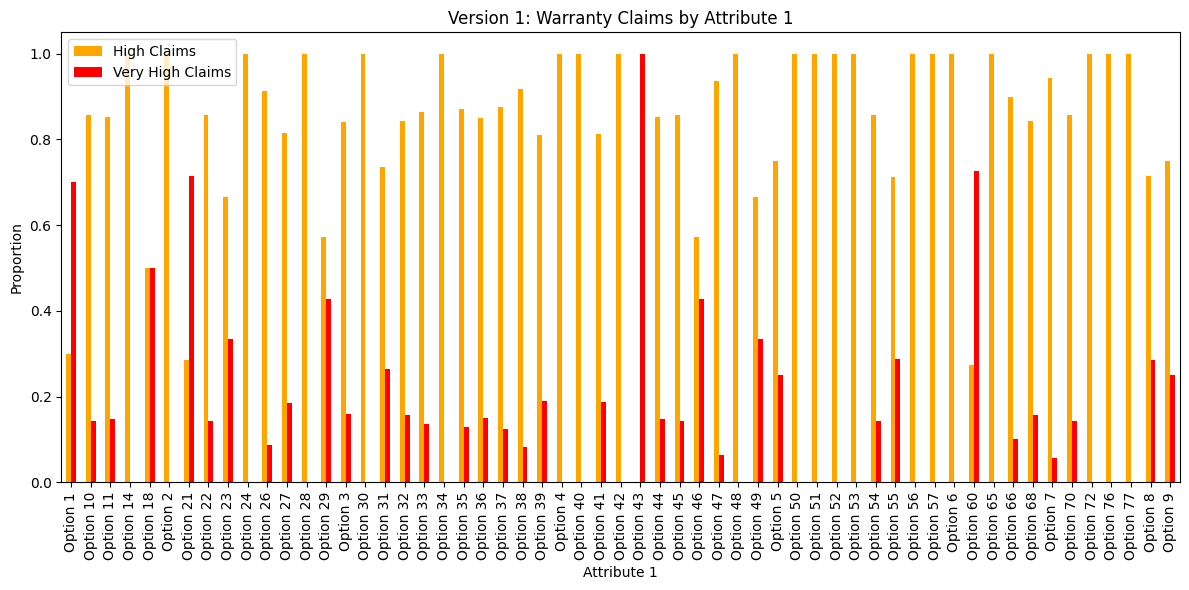

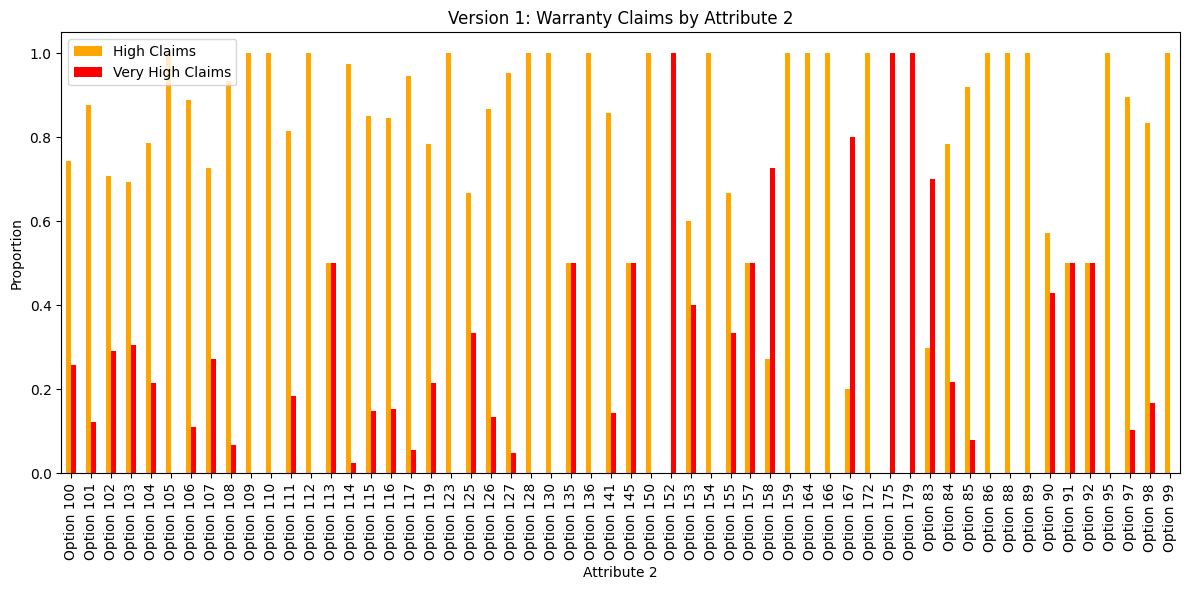

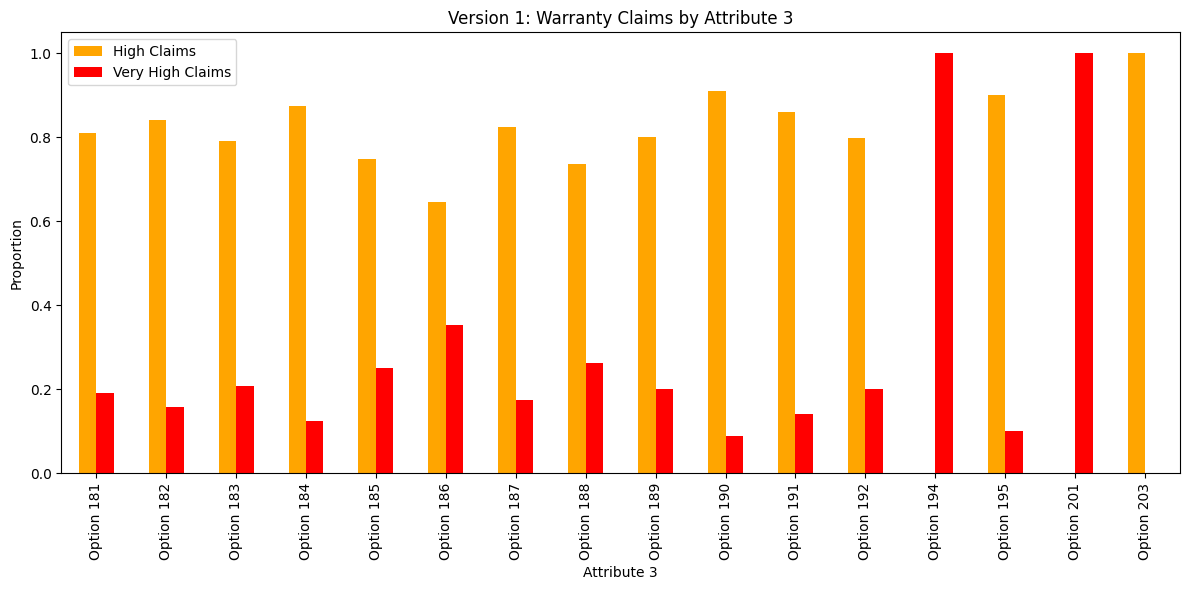

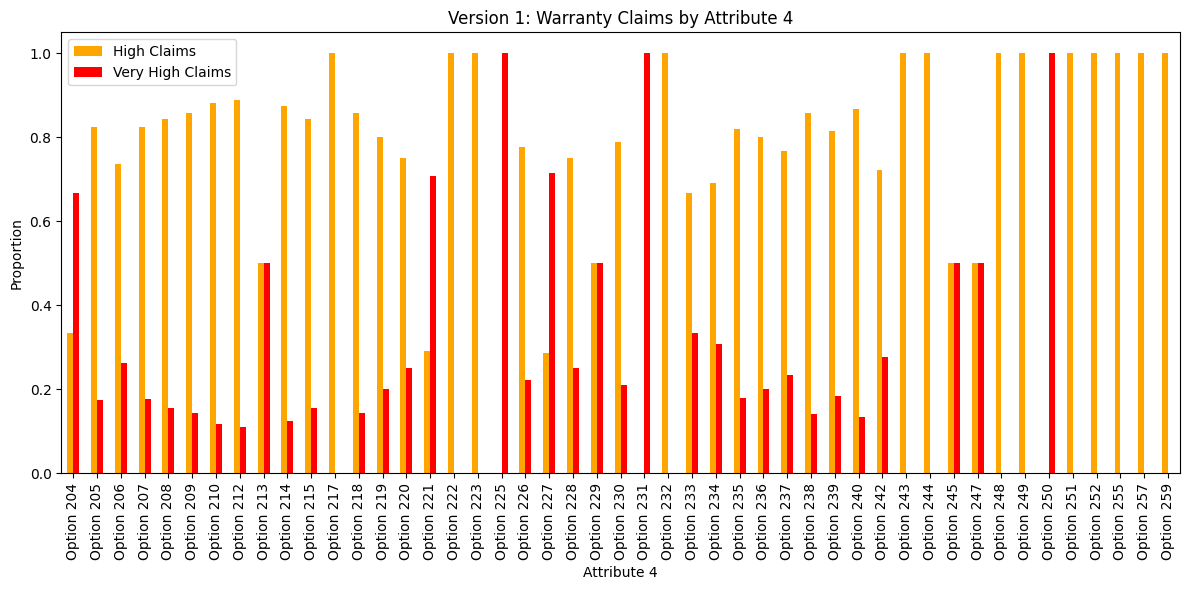

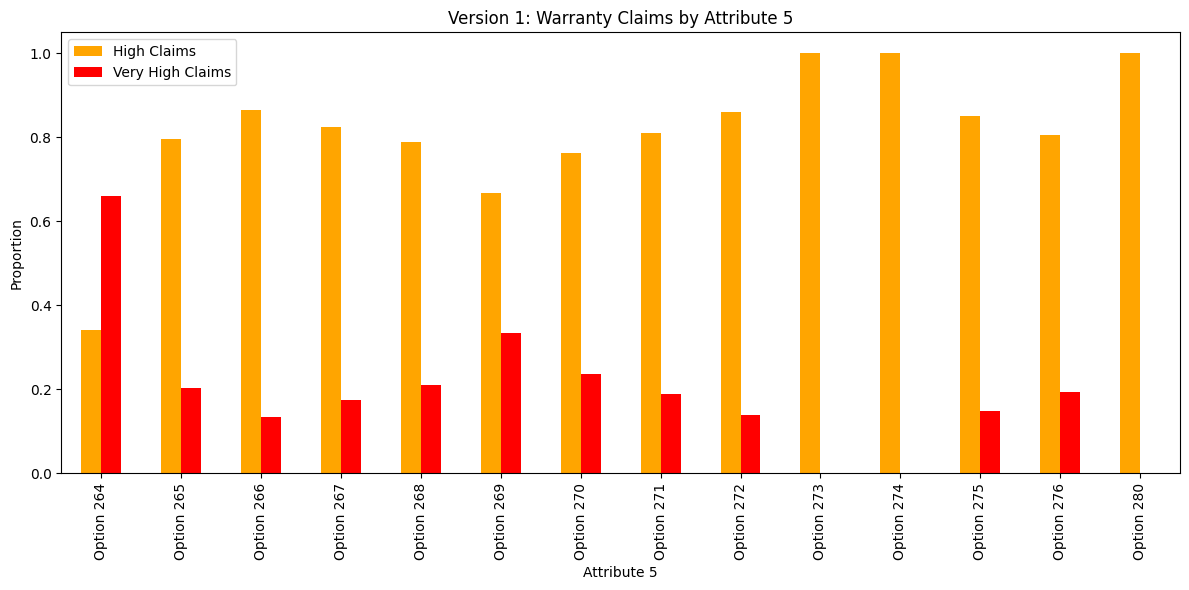

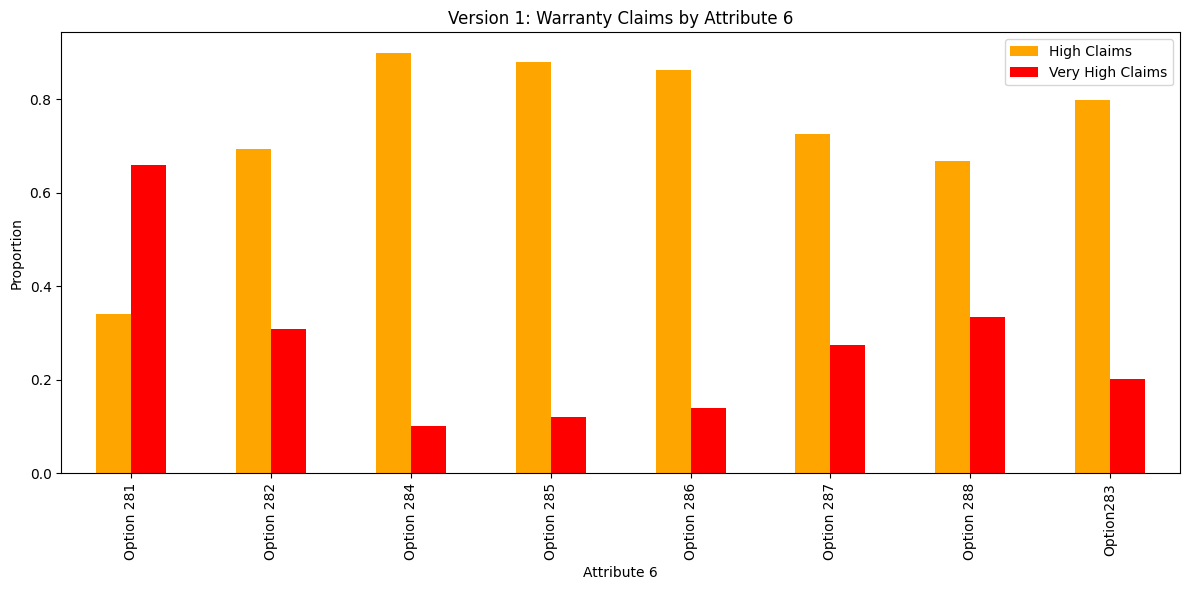

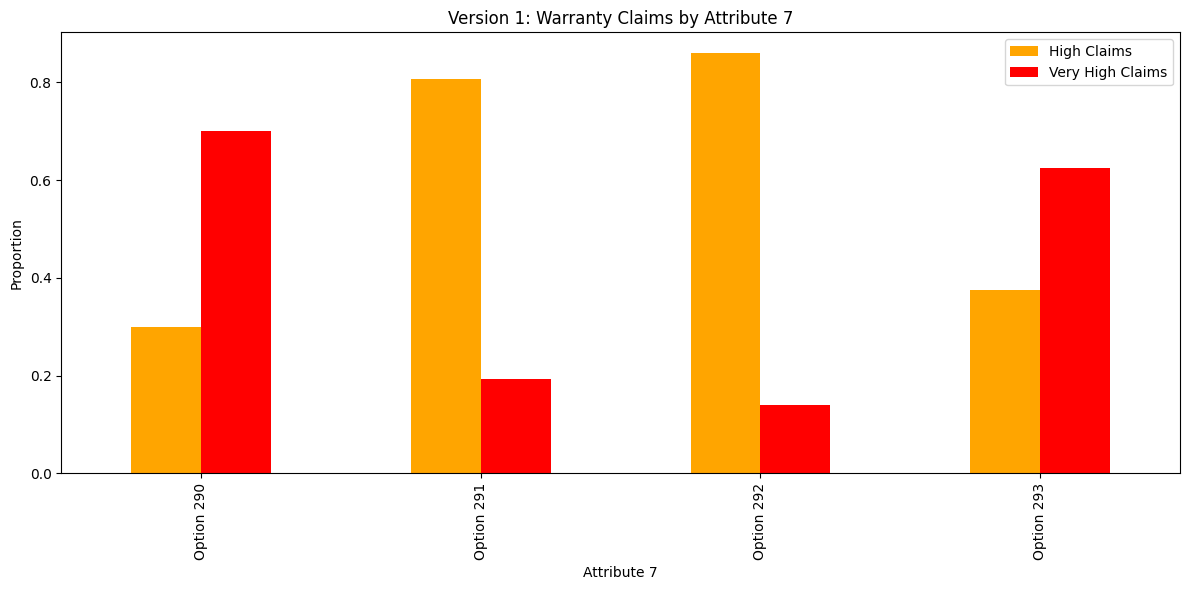

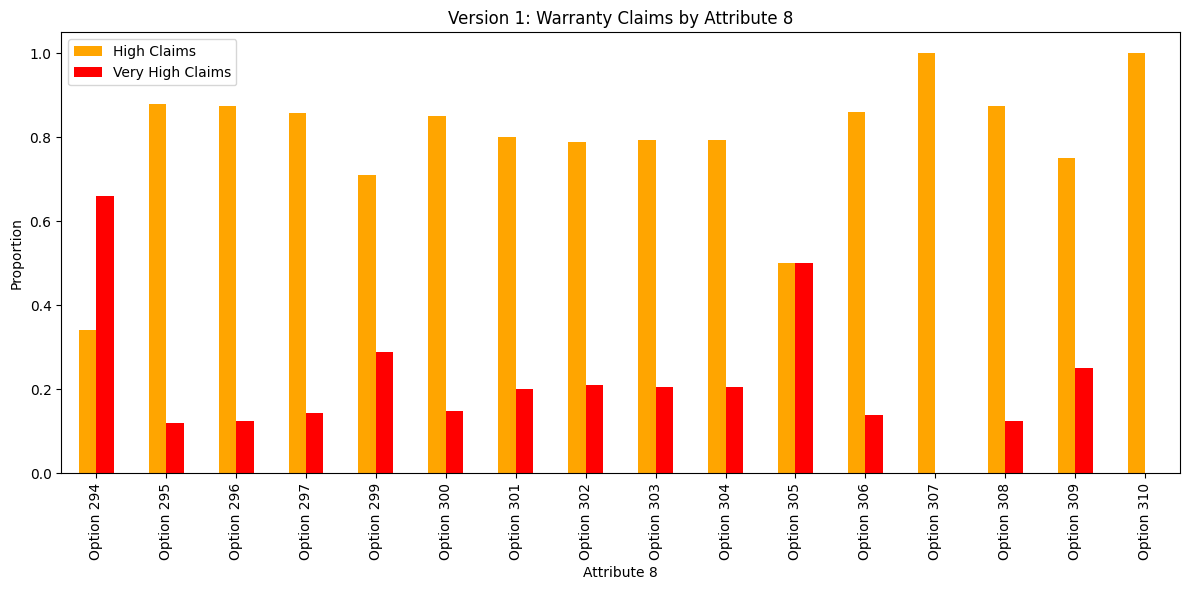

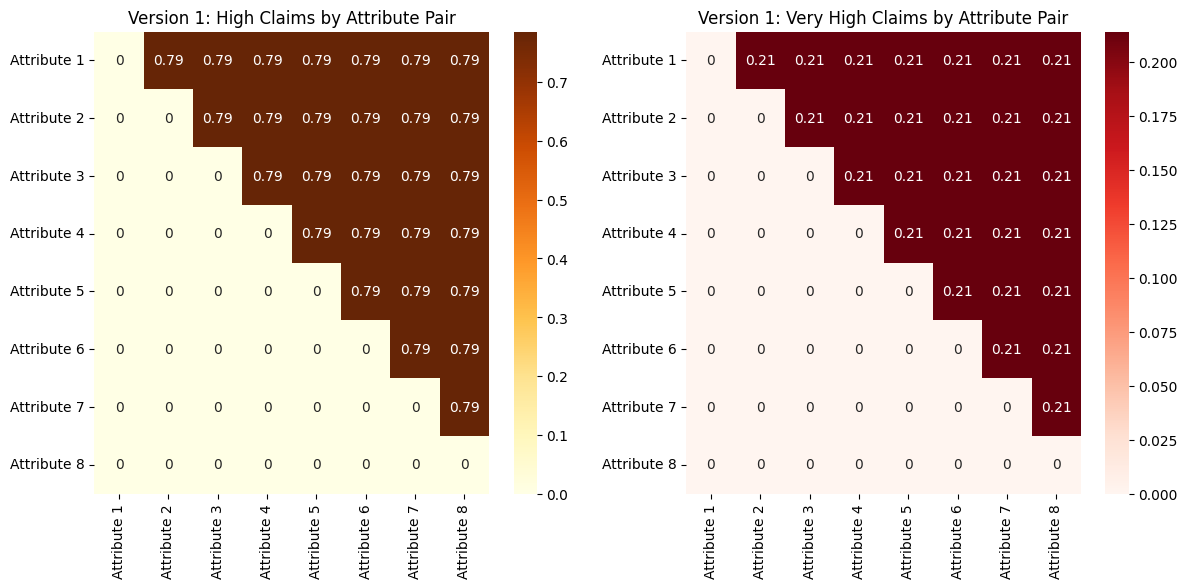


Version 1: Trucks with High Claim Costs
Style    Truck_ID   
Style 4  Truck 25702    4
Style 3  Truck 16888    4
Style 4  Truck 3141     4
         Truck 17360    3
Style 1  Truck 830      3
Style 4  Truck 19655    3
Style 1  Truck 588      3
Style 4  Truck 17727    3
         Truck 19646    3
         Truck 29586    3
dtype: int64

Version 1: Trucks with Very High Claim Costs
Style    Truck_ID   
Style 4  Truck 29585    5
         Truck 21774    4
         Truck 28145    4
         Truck 21773    3
         Truck 29586    3
         Truck 46939    3
         Truck 4722     3
         Truck 24606    2
Style 3  Truck 24634    2
Style 4  Truck 18042    2
dtype: int64

Version 1: Trucks with Most Warranty Claims
Truck_ID
Truck 29586    6
Truck 21774    6
Truck 28145    5
Truck 29585    5
Truck 26029    4
Truck 25702    4
Truck 16888    4
Truck 3141     4
Truck 46939    4
Truck 8067     4
dtype: int64


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Assuming merged_data is your preprocessed DataFrame

# Helper function to plot proportions
def plot_proportions(proportions, title, xlabel, ylabel, rotation=90):
    fig, ax = plt.subplots(figsize=(12, 6))
    proportions.plot(kind='bar', ax=ax, color=['red', 'blue'])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

### VERSION 1 ANALYSIS (Only Scale Claim Cost) ###

def filter_data_version1(data):
    return data[data['Scale Claim Cost'].isin(['High', 'Very High'])]

def analyze_options_increased_warranty_costs_v1(data):
    for attr in [f'Attribute {i}' for i in range(1, 9)]:
        high_proportion = data[data['Scale Claim Cost'] == 'High'].groupby(attr).size() / data.groupby(attr).size()
        very_high_proportion = data[data['Scale Claim Cost'] == 'Very High'].groupby(attr).size() / data.groupby(attr).size()
        
        proportions = pd.DataFrame({'High Claims': high_proportion, 'Very High Claims': very_high_proportion}).fillna(0)
        plot_proportions(proportions, f"Version 1: Warranty Claims by {attr}", attr, "Proportion")

def analyze_pairs_exacerbate_warranty_claims_v1(data):
    attributes = [f'Attribute {i}' for i in range(1, 9)]
    high_matrix = pd.DataFrame(index=attributes, columns=attributes, data=0.0)
    very_high_matrix = pd.DataFrame(index=attributes, columns=attributes, data=0.0)
    
    for (attr1, attr2) in combinations(attributes, 2):
        high_pairs = data[(data[attr1] == data[attr1]) & (data[attr2] == data[attr2])]
        very_high_pairs = data[(data[attr1] == data[attr1]) & (data[attr2] == data[attr2])]
        
        high_matrix.loc[attr1, attr2] = len(high_pairs[high_pairs['Scale Claim Cost'] == 'High']) / len(data)
        very_high_matrix.loc[attr1, attr2] = len(very_high_pairs[very_high_pairs['Scale Claim Cost'] == 'Very High']) / len(data)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(high_matrix, annot=True, cmap="YlOrBr", ax=ax1)
    sns.heatmap(very_high_matrix, annot=True, cmap="Reds", ax=ax2)
    ax1.set_title("Version 1: High Claims by Attribute Pair")
    ax2.set_title("Version 1: Very High Claims by Attribute Pair")
    plt.show()

def analyze_styles_trucks_increased_warranty_costs_v1(data):
    high_claims = data[data['Scale Claim Cost'] == 'High'].groupby(['Style', 'Truck_ID']).size()
    very_high_claims = data[data['Scale Claim Cost'] == 'Very High'].groupby(['Style', 'Truck_ID']).size()
    
    print("\nVersion 1: Trucks with High Claim Costs")
    print(high_claims.sort_values(ascending=False).head(10))
    print("\nVersion 1: Trucks with Very High Claim Costs")
    print(very_high_claims.sort_values(ascending=False).head(10))

def analyze_trucks_with_most_claims_v1(data):
    claims_per_truck = data.groupby('Truck_ID').size()
    print("\nVersion 1: Trucks with Most Warranty Claims")
    print(claims_per_truck.sort_values(ascending=False).head(10))

# Execute Analysis for Version 1
data_v1 = filter_data_version1(merged_data)
print("=== Version 1 Analysis ===")
analyze_options_increased_warranty_costs_v1(data_v1)
analyze_pairs_exacerbate_warranty_claims_v1(data_v1)
analyze_styles_trucks_increased_warranty_costs_v1(data_v1)
analyze_trucks_with_most_claims_v1(data_v1)


In [62]:
# Below we used XGBoost Classifier (XGBClassifier), which is a popular implementation for gradient-boosted decision trees. 
# XGBoost is known for its speed and performance, particularly on structured/tabular datasets. 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import category_encoders as ce

# Helper to encode categorical columns and prepare target
def prepare_data_for_model(merged_data, version='version1'):
    # Define target based on version
    if version == 'version1':
        merged_data['Target'] = merged_data['Scale Claim Cost'].apply(lambda x: 1 if x in ['High', 'Very High'] else 0)
    elif version == 'version2':
        merged_data['Target'] = merged_data.apply(
            lambda row: 1 if row['Scale Claim Cost'] in ['High', 'Very High'] and row['Scale Labor Cost'] in ['High', 'Very High'] else 0,
            axis=1
        )
    
    # Separate features and target
    categorical_cols = ['Style', 'Truck_ID'] + [f'Attribute {i}' for i in range(1, 9)]
    X = merged_data[categorical_cols]
    y = merged_data['Target']
    
    # Encode categorical variables
    target_encoder = ce.TargetEncoder(cols=categorical_cols)
    X_encoded = target_encoder.fit_transform(X, y)
    
    return X_encoded, y

# Prepare data for Version 1
X_v1, y_v1 = prepare_data_for_model(merged_data, version='version1')
X_v2, y_v2 = prepare_data_for_model(merged_data, version='version2')

# Model training function
def train_xgboost_model(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Set up the model and hyperparameter grid
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [6, 8, 10],
        'n_estimators': [100, 200]
    }
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Output results
    print(f"Best Parameters: {grid_search.best_params_}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return best_model

print("=== Version 1 Model ===")
best_model_v1 = train_xgboost_model(X_v1, y_v1)

print("\n=== Version 2 Model ===")
best_model_v2 = train_xgboost_model(X_v2, y_v2)


=== Version 1 Model ===
Best Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     36388
           1       0.95      0.06      0.12       621

    accuracy                           0.98     37009
   macro avg       0.97      0.53      0.55     37009
weighted avg       0.98      0.98      0.98     37009


=== Version 2 Model ===
Best Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36948
           1       0.67      0.03      0.06        61

    accuracy                           1.00     37009
   macro avg       0.83      0.52      0.53     37009
weighted avg       1.00      1.00      1.00     37009



GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.63      0.51     29719
           1       0.47      0.12      0.20     29968
           2       0.41      0.22      0.29     29732
           3       0.42      0.51      0.46     29732
           4       0.54      0.82      0.65     29991

    accuracy                           0.46    149142
   macro avg       0.45      0.46      0.42    149142
weighted avg       0.45      0.46      0.42    149142

Accuracy Score: 0.4616606991994207


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 9 artists>

Text(0.5, 0, 'Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Feature Importance in Random Forest Model (Version 1)')

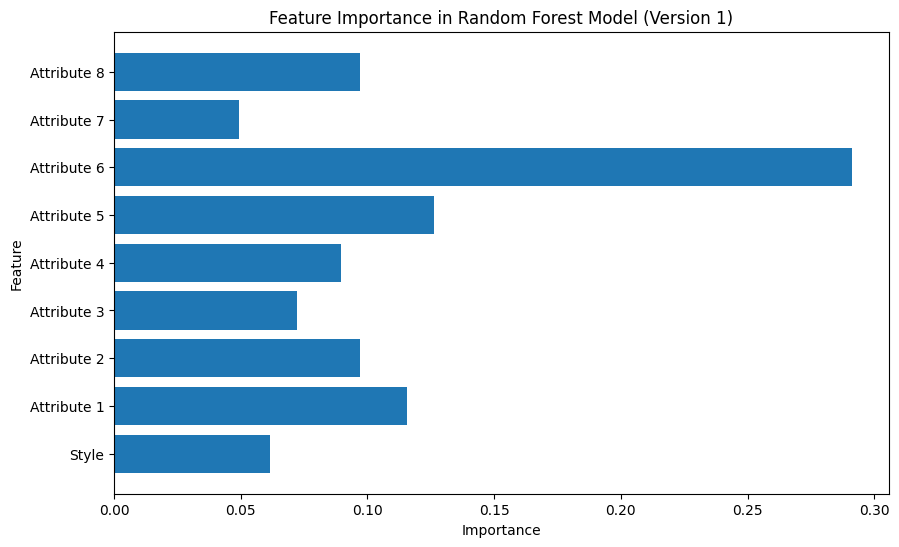

In [71]:
# Random Forest Classifier - Random Forest is an ensemble learning method that creates multiple decision trees and merges them to produce a more accurate and stable prediction. 
# It uses a majority vote mechanism across trees to determine the final classification.
# The class_weight='balanced' parameter adjusts the weights of classes to handle the class imbalance within the dataset.
# We used Feature Engineering and Preprocessing:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# Prepare the dataset
X = merged_data.drop(columns=['Scale Claim Cost', 'Scale Labor Cost', 'Truck_ID', 'Claim Number'])
y = merged_data['Scale Claim Cost']

# Encode categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the RandomForest model with balanced class weight
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Expanded hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Feature Importance Plot
import matplotlib.pyplot as plt

feature_importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model (Version 1)")
plt.show()


In [11]:
# Random Forest Classifier - Feature Engineering with Polynomial and Interaction Terms:
# Handling Class Imbalance with SMOTE
# Expanded Hyperparameter Search: In the updated model, the hyperparameter grid was expanded to include a wider range of options for 
#     n_estimators, max_depth, min_samples_split, and min_samples_leaf
# Class Weight Balancing in Random Forest:

from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Define `X` and `y`
X = merged_data.drop(columns=['Scale Claim Cost', 'Scale Labor Cost', 'Truck_ID', 'Claim Number'])
y = merged_data['Scale Claim Cost']

# Encode categorical features in `X` with LabelEncoder
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Step 2: Apply Polynomial and Interaction Terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Step 3: Resampling to Address Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_poly, y)

# Step 4: Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 5: Model Training and Evaluation
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Step 6: Evaluation
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

        High       0.65      0.69      0.67     29836
         Low       0.58      0.41      0.48     29968
      Medium       0.57      0.53      0.55     29743
   Very High       0.70      0.90      0.78     29658
    Very Low       0.62      0.62      0.62     29937

    accuracy                           0.63    149142
   macro avg       0.62      0.63      0.62    149142
weighted avg       0.62      0.63      0.62    149142

Accuracy Score: 0.629514154295906


In [ ]:
# Here we combine Random Forest and XGBoost classifiers, along with several techniques to enhance model accuracy. 

# Imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

# Loading and Preparing Data
# Assume `merged_data` is already loaded

# Target variable and features
y = merged_data['Scale Claim Cost']
X = merged_data.drop(columns=['Scale Claim Cost', 'Scale Labor Cost', 'Truck_ID', 'Claim Number'])  # Adjust as needed

# Step 1: Encode Categorical Variables
# Convert categorical variables to numeric using Label Encoding or One-Hot Encoding
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# Step 2: Feature Engineering - Adding Polynomial and Interaction Terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Step 3: Resampling to Address Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_poly, y)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 4: Feature Selection using Recursive Feature Elimination (RFE)
# We'll use Random Forest as the estimator in RFE
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=15, step=1)
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)

# Step 5: Hyperparameter Tuning for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [5, 10],
    'class_weight': ['balanced']  # Using balanced weights for class imbalance
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy'
)

grid_search_rf.fit(X_train_rfe, y_train)
best_rf = grid_search_rf.best_estimator_

# Step 6: Ensemble Model with VotingClassifier (RandomForest + XGBoost)
# Train XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

# Voting classifier with soft voting
ensemble_model = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('xgb', xgb_model)
], voting='soft')

ensemble_model.fit(X_train_rfe, y_train)

# Step 7: Evaluate the Model
y_pred = ensemble_model.predict(X_test_rfe)

# Print Classification Report and Accuracy Score
print("=== Ensemble Model (RandomForest + XGBoost) ===")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Step 8: Feature Importance (for RandomForest part of the ensemble)
# Plot feature importance for the RandomForest model
rf_feature_importances = best_rf.feature_importances_
selected_features = X.columns[rfe_selector.support_]  # Only the features selected by RFE

plt.figure(figsize=(10, 6))
plt.barh(selected_features, rf_feature_importances)
plt.xlabel("Importance")
plt.title("Feature Importance in Random Forest Model (Version 1)")
plt.show()
